In [1]:
#necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

## Import Data

In [2]:
silver = pd.read_csv('data/Silver_Futures_Historical_Data.csv', index_col='Date', parse_dates=True)
silver.sort_index(inplace=True)
price_silver = silver['Price']

In [3]:
gold = pd.read_csv('data/Gold_Futures_Historical_Data.csv', index_col='Date', parse_dates=True)
gold.sort_index(inplace=True)
price_gold = gold['Price']
price_gold = price_gold.apply(lambda x: pd.to_numeric(x.replace(',',''), errors='coerce'))

In [4]:
all_weekdays = pd.date_range(start='2019-01-01', end='2019-07-20', freq='B')
price_silver = price_silver.reindex(all_weekdays)
price_gold = price_gold.reindex(all_weekdays)

In [5]:
df = pd.concat([price_silver, price_gold], axis=1)

In [6]:
df.columns = ["Silver", "Gold"]
df = df.dropna(how='any')

In [7]:
df.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2019-07-08', '2019-07-09', '2019-07-10', '2019-07-11',
               '2019-07-12', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19'],
              dtype='datetime64[ns]', length=144, freq='B')

In [8]:
df.head(10)

,Silver,Gold
2019-01-01,15.523,1283.35
2019-01-02,15.907,1296.90
2019-01-03,16.061,1307.70
2019-01-04,16.052,1298.70
2019-01-07,16.021,1302.90
2019-01-08,15.988,1298.80
2019-01-09,16.009,1304.90
2019-01-10,15.918,1300.50
2019-01-11,15.931,1302.70
2019-01-14,15.962,1304.60


## Extract specific period and commodity type

In [9]:
#three command line arguments:
def extract_data(df, start, end, type_info):
    target = df.loc[start:end, type_info]
    return target

In [10]:
silver = extract_data(df,'2019-01-01', '2019-07-19', "Silver")
gold = extract_data(df, '2019-01-01', '2019-07-19', "Gold")

## Statistical properties of Data

In [11]:
silver_result = silver.describe()
silver_result

count    144.000000
mean      15.391882
std        0.495903
min       14.401000
25%       15.028750
50%       15.338500
75%       15.842500
max       16.464000
Name: Silver, dtype: float64

In [12]:
gold_result = gold.describe()
gold_result

count     144.000000
mean     1321.727083
std        43.563037
min      1272.000000
25%      1293.175000
50%      1307.700000
75%      1331.675000
max      1444.250000
Name: Gold, dtype: float64

## Run an ETS Decomposition

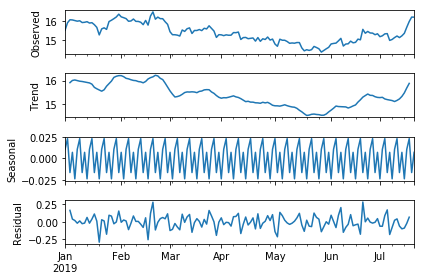

In [13]:
s_result = seasonal_decompose(silver, model='additive')
s_result.plot();

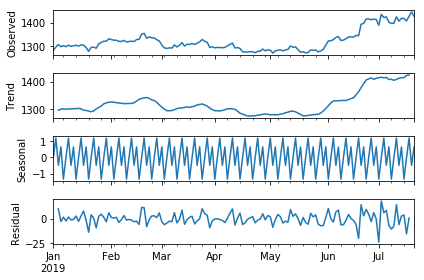

In [14]:
g_result = seasonal_decompose(gold, model='additive')
g_result.plot();

In [15]:
g_result.trend.describe()

count     140.000000
mean     1320.584000
std        41.100063
min      1276.300000
25%      1294.322500
50%      1305.450000
75%      1331.795000
max      1424.060000
Name: Gold, dtype: float64

## Tests for Stationarity

In [16]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
# Augmented Dickey-Fuller Test
adf_test(silver, title='Silver')

Augmented Dickey-Fuller Test: Silver
ADF test statistic       -1.493798
p-value                   0.536577
# lags used               1.000000
# observations          142.000000
critical value (1%)      -3.477262
critical value (5%)      -2.882118
critical value (10%)     -2.577743
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [18]:
# Augmented Dickey-Fuller Test
adf_test(gold, title='Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic       -0.076146
p-value                   0.951763
# lags used               1.000000
# observations          142.000000
critical value (1%)      -3.477262
critical value (5%)      -2.882118
critical value (10%)     -2.577743
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Model selection

In [19]:
auto_arima(silver,seasonal=False).summary()

/Users/qizhihua/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/qizhihua/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/qizhihua/anaconda3/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  57.354
Method:                           css   S.D. of innovations              0.162
Date:                Mon, 22 Jul 2019   AIC                           -110.709
Time:                        00:17:07   BIC                           -104.783
Sample:                             1   HQIC                          -108.301
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.014      0.347      0.729      -0.022       0.031
==============================================================================
"""

In [20]:
auto_arima(gold,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -537.871
Method:                       css-mle   S.D. of innovations             10.397
Date:                Mon, 22 Jul 2019   AIC                           1083.742
Time:                        00:17:09   BIC                           1095.594
Sample:                             1   HQIC                          1088.558
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0195      0.841      1.213      0.227      -0.628       2.667
ar.L1.D.y     -0.9632      0.058    -16.718      0.000      -1.076      -0.850
ma.L1.D.y      0.8982      0.085     10.509      0.000       0.731       1.066
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0382           +0.0000j            1.0382            0.5000
MA.1           -1.1133           +0.0000j            1.1133            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
silver_stepwise_fit = auto_arima(silver, start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

silver_stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=-110.709, BIC=-104.783, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-110.568, BIC=-101.680, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-110.317, BIC=-101.428, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-108.893, BIC=-97.042, Fit time=0.068 seconds
Total fit time: 0.118 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  57.354
Method:                           css   S.D. of innovations              0.162
Date:                Mon, 22 Jul 2019   AIC                           -110.709
Time:                        00:17:10   BIC                           -104.783
Sample:                             1   HQIC                          -108.301
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.014      0.347      0.729      -0.022       0.031
==============================================================================
"""

In [22]:
gold_stepwise_fit = auto_arima(gold, start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

gold_stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=1086.288, BIC=1092.214, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1084.371, BIC=1093.259, Fit time=0.014 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1084.911, BIC=1093.800, Fit time=0.018 seconds
Fit ARIMA: order=(2, 1, 0); AIC=1085.663, BIC=1097.515, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 1); AIC=1083.742, BIC=1095.594, Fit time=0.073 seconds
Fit ARIMA: order=(2, 1, 2); AIC=1089.591, BIC=1107.368, Fit time=0.186 seconds
Fit ARIMA: order=(2, 1, 1); AIC=1084.925, BIC=1099.739, Fit time=0.071 seconds
Fit ARIMA: order=(1, 1, 2); AIC=1087.585, BIC=1102.399, Fit time=0.075 seconds
Total fit time: 0.470 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -537.871
Method:                       css-mle   S.D. of innovations             10.397
Date:                Mon, 22 Jul 2019   AIC                           1083.742
Time:                        00:17:13   BIC                           1095.594
Sample:                             1   HQIC                          1088.558
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0195      0.841      1.213      0.227      -0.628       2.667
ar.L1.D.y     -0.9632      0.058    -16.718      0.000      -1.076      -0.850
ma.L1.D.y      0.8982      0.085     10.509      0.000       0.731       1.066
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0382           +0.0000j            1.0382            0.5000
MA.1           -1.1133           +0.0000j            1.1133            0.5000
-----------------------------------------------------------------------------
"""

## ACF plot

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

In [24]:
#gold = gold.apply(lambda x: np.log(x))
g_diff = gold - gold.shift(1)
s_diff = silver - silver.shift(1)
g_diff = g_diff.dropna()
s_diff = s_diff.dropna()

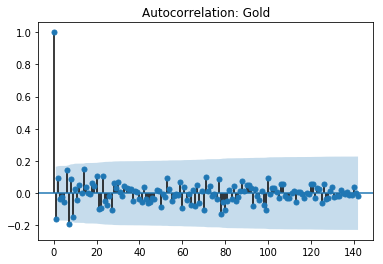

In [25]:
title = 'Autocorrelation: Gold'
plot_acf(g_diff, title=title);

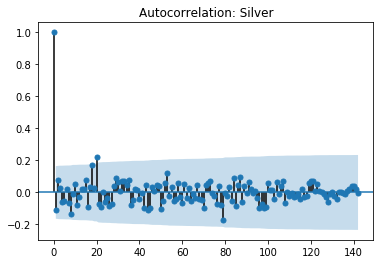

In [26]:
title = 'Autocorrelation: Silver'
plot_acf(s_diff,title=title);